# Computational Techniques for Differential Equations  
**Master in Applied and Computational Mathematics**  
**Academic Year 2025/2026**  


Jose Enrique Zafra Mena

Francisco Javier Miró Rodriguez




---

## **Lab 3 – Numerical Methods for the Heat Equation**

Consider the **parabolic partial differential equation (PDE):**

$$
\begin{aligned}
\text{PDE:} \quad & \frac{\partial u}{\partial t} = \Delta u, \quad (x, y) \in \Omega = [0,1]^2, \quad t > 0, \\[4pt]
\text{Initial condition:} \quad & u(x, y, 0) = e^{-((x-0.5)^2 + (y-0.5)^2) / 0.2^2}, \\[4pt]
\text{Boundary conditions:} \quad & u(x, y, t) = 0, \quad (x, y) \in \partial\Omega.
\end{aligned}
$$

---

### **Tasks**

#### **(a) Spatial Discretization – Construction of the Laplacian Matrix**

Implement the following Python function:

```python
def laplacian_matrix(m, h):
    ...
    return A
```

This function should construct the **5-point finite difference Laplacian** matrix $A$ on the domain $\Omega$.

* Enforce **Dirichlet boundary conditions** by excluding boundary nodes from the system of unknowns.
* Use the `scipy.sparse` module for efficient storage and operations with sparse matrices.



In [ ]:
import numpy as np
from scipy.sparse import diags, eye, kron

def laplacian_matrix(m, h):
    """Return the 5-point Laplacian on an m x m interior grid with spacing h.

    Parameters
    ----------
    m : int
        Interior nodes.
    h : float
        Grid spacing.
    """

    main = -2.0 * np.ones(m)
    off = np.ones(m - 1)
    T = diags([off, main, off], offsets=[-1, 0, 1], shape=(m, m), format='csc') / (h ** 2)
    I = eye(m, format='csc')

    return kron(I, T, format='csc') + kron(T, I, format='csc')


---

#### **(b) Time Integration – Explicit 4th-Order Runge–Kutta Scheme**

Implement a **4th-order explicit Runge–Kutta (RK4)** method to integrate the semi-discrete system:

$$
u_t = A u,
$$

where $A$ is the discrete Laplacian and $u$ is the vector of unknowns corresponding to interior grid points.

* Choose a time step $k$ that ensures numerical stability.
  For the heat equation, stability generally requires
  $$
  k \leq C\,h^2,
  $$
  where $C$ can be estimated theoretically or determined empirically.
* Integrate the system up to $T = 0.3$.
* Visualize the numerical solution at $T = 0.3$ using a **surface plot** or **heatmap**.



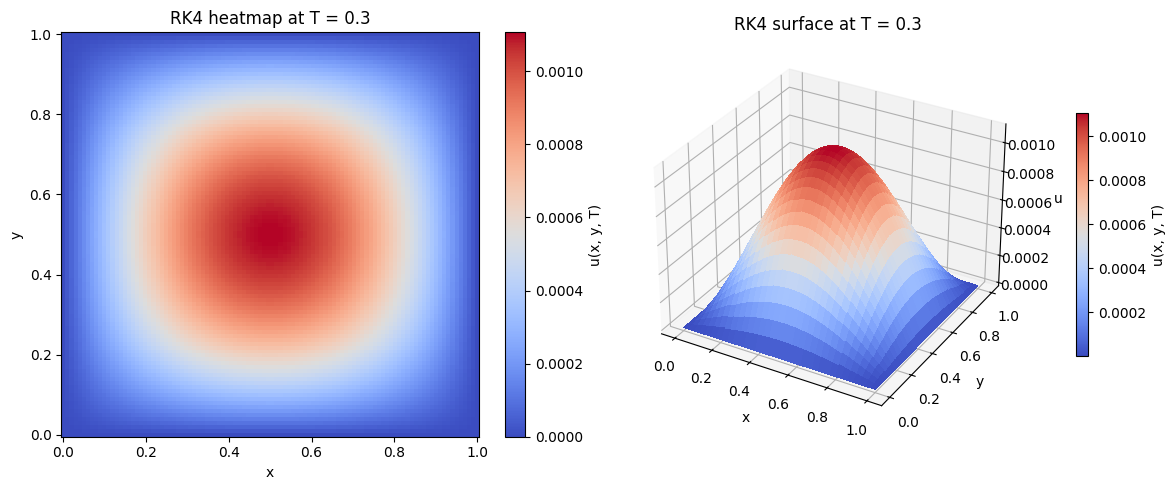

In [22]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


def initial_condition(x, y):
    return np.exp(-(((x - 0.5) ** 2 + (y - 0.5) ** 2) / 0.2 ** 2))

def rk4_heat_solver(m=30, T=0.3, cfl=0.2):
    """Integrate u_t = A u with RK4 up to time T on an m x m interior grid."""
    h = 1.0 / (m + 1)
    A = laplacian_matrix(m, h)

    grid = np.linspace(0.0, 1.0, m + 2)
    X_int, Y_int = np.meshgrid(grid[1:-1], grid[1:-1], indexing='xy')
    u = initial_condition(X_int, Y_int).ravel(order='C')

    dt = min(cfl * h ** 2, T)
    steps = max(1, int(np.ceil(T / dt)))
    dt = T / steps

    def rk4_step(vec):
        k1 = A @ vec
        k2 = A @ (vec + 0.5 * dt * k1)
        k3 = A @ (vec + 0.5 * dt * k2)
        k4 = A @ (vec + dt * k3)
        return vec + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

    for _ in range(steps):
        u = rk4_step(u)

    U_full = np.zeros((m + 2, m + 2))
    U_full[1:-1, 1:-1] = u.reshape((m, m), order='C')
    return grid, grid, U_full

x, y, U_T = rk4_heat_solver(m=100)
X, Y = np.meshgrid(x, y, indexing='xy')

fig = plt.figure(figsize=(12, 5))
ax_heat = fig.add_subplot(1, 2, 1)
pcm = ax_heat.pcolormesh(X, Y, U_T, shading='auto', cmap='coolwarm')
ax_heat.set(xlabel='x', ylabel='y', title='RK4 heatmap at T = 0.3')
fig.colorbar(pcm, ax=ax_heat, label='u(x, y, T)')

ax_surf = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax_surf.plot_surface(X, Y, U_T, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax_surf.set(xlabel='x', ylabel='y', zlabel='u', title='RK4 surface at T = 0.3')
fig.colorbar(surf, ax=ax_surf, shrink=0.6, pad=0.1, label='u(x, y, T)')

plt.tight_layout()
plt.show()


---

#### **(c) Implicit Time Integration – 4th-Order BDF Scheme**

Implement the **4th-order Backward Differentiation Formula (BDF4)** for the same semi-discrete problem:

$$
\frac{d u}{d t} = A u.
$$

The BDF4 method is a **four-step implicit scheme**, given by

$$
25u_{n+1} - 48u_n + 36u_{n-1} - 16u_{n-2} + 3u_{n-3} = 12k\,A u_{n+1}.
$$

At each time step, this leads to the **linear system**

$$
(25I - 12kA)u_{n+1} = 48u_n - 36u_{n-1} + 16u_{n-2} - 3u_{n-3}.
$$

* Use `scipy.sparse` data structures and solvers for computational efficiency.
* Since BDF4 is a **multi-step method**, it requires the first four time levels to be initialized.
  Use a suitable **one-step method** to compute the initial values.
* Discuss the **stability properties** of the method:

  * Does BDF4 impose a restriction on the time step $k$?
  * Why are implicit schemes like BDF4 often preferred for **stiff PDEs**?

---

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import eye
from scipy.sparse.linalg import splu


def bdf4_heat_solver(m=30, T=0.3, C=1.0):
    """Integrate u_t = A u with BDF4 up to T on an m x m interior grid."""
    h = 1.0 / (m + 1)
    A = laplacian_matrix(m, h)

    grid = np.linspace(0.0, 1.0, m + 2)
    X_int, Y_int = np.meshgrid(grid[1:-1], grid[1:-1], indexing='xy')
    u0 = initial_condition(X_int, Y_int).ravel(order='C')

    dt = min(C * h ** 2, T / 4)
    steps = max(4, int(np.ceil(T / dt)))
    dt = T / steps

    def rk4_step(vec, step_dt):
        k1 = A @ vec
        k2 = A @ (vec + 0.5 * step_dt * k1)
        k3 = A @ (vec + 0.5 * step_dt * k2)
        k4 = A @ (vec + step_dt * k3)
        return vec + (step_dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

    trajectory = [u0]
    current = u0
    for _ in range(3):
        current = rk4_step(current, dt)
        trajectory.append(current)

    I = eye(A.shape[0], format='csc')
    solver = splu(25.0 * I - 12.0 * dt * A)

    for _ in range(3, steps):
        u_nm3, u_nm2, u_nm1, u_n = trajectory[-4:]
        rhs = 48.0 * u_n - 36.0 * u_nm1 + 16.0 * u_nm2 - 3.0 * u_nm3
        next_u = solver.solve(rhs)
        trajectory.append(next_u)

    return trajectory[-1], dt, steps




Since A is definite negative, all the eigenvalues are strictly negative and reals. Therefore, since the stability region for the BDF4 is known and the line of the real negatives numbers is inside this region, hence we know that for any $k>0$, $k\cdot \lambda$ is in the region, and therefore stable (as seen in the MOL figures).



The implicits methods are better for stiff problems since they have a way bigger convergence region of stability. Therefore $k$ doesnt have to be too small, which is needed because of the large differences between the eigenvalues.
